In [ ]:
#!pip install catboost
#!pip install umap-learn

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans

#import umap

from sklearn import linear_model
from sklearn import ensemble
from sklearn import svm
import xgboost as xgb
import lightgbm as lgbm
from catboost import CatBoostClassifier

In [ ]:
def apk(actual, predicted, k=10):
    if not actual:
        return 0.0

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')
ori = pd.read_csv('trainn.csv')
train.drop('id', inplace=True, axis=1)
test.drop('id', inplace=True, axis=1)
train = pd.concat([train,ori])

In [ ]:
#train.drop(['toenail_loss', 'ulcers', 'speech_problem'], inplace=True, axis=1)
#test.drop(['toenail_loss', 'ulcers', 'speech_problem'], inplace=True, axis=1)

In [ ]:
enc = OrdinalEncoder()
train['prognosis'] = enc.fit_transform(train[['prognosis']])

In [ ]:
target = train['prognosis']
train.drop('prognosis', inplace=True, axis=1)

In [ ]:
def fe(df):
  gejala = {'hyperbilirubinemia': ['jaundice', 'yellow_skin' , 'yellow_eyes'],
            #'abnormal_hemostasis': ['mouth_bleed', 'nose_bleed', 'gastro_bleeding', 'gum_bleed'],
            #'anasarca': ['pleural_effusion', 'ascites'],
            'kidney_failure': ['urination_loss' , 'cocacola_urine'],
            #'meningitis': ['orbital_pain', 'neck_pain', 'light_sensitivity', 'stiff_neck'],
            #'neurological_focal': ['coma', 'convulsion', 'confusion', 'paralysis', 'speech_problem'],
            #'fever': ['sudden_fever', 'rigor', 'hyperpyrexia' ],
            #'hypereosinophilia': ['rash', 'swelling'],
            #'digestive_issues': ['vomiting', 'diarrhea', 'nausea', 'stomach_pain', 'abdominal_pain'],
            #'skin_appendages': ['skin_lesions', 'toe_inflammation', 'finger_inflammation', 'lips_irritation', 'ulcers', 'toenail_loss'],
            #'flu-like_illness': ['headache', 'muscle_pain', 'joint_pain', 'chills', 'myalgia', 'fatigue']
  }
  for key in gejala:
    df[key] = df[gejala[key]].sum(axis=1)

#fe(train)
#fe(test)

In [ ]:
def fe2(df):
  cluster_0 = df.columns[df.columns.str.contains('pain')]
  cluster_1 = df.columns[df.columns.str.contains('inflammation')]
  cluster_2 = df.columns[df.columns.str.contains('bleed')]
  cluster_3 = df.columns[df.columns.str.contains('skin')].tolist() + ['itchiness']

  df['cluster_0'] = df[cluster_0].sum(axis=1)
  df['cluster_1'] = df[cluster_1].sum(axis=1)
  #df['cluster_2'] = df[cluster_2].sum(axis=1)
  df['cluster_3'] = df[cluster_3].sum(axis=1)

fe2(train)
fe2(test)

In [ ]:
def fe3(df):
  km = KMeans(n_clusters = 3)
  km.fit(df)
  df['cluster'] = km.predict(df)
  df['cluser'] = df['cluster'].astype('category')

#fe3(train)
#fe3(test)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train, target, random_state=42)

model = svm.SVC(probability=True).fit(x_train, y_train)
predictions = model.predict_proba(x_test)
top_3 = np.argsort(-predictions, axis=1)[:,:3]
score = mapk(y_test.values.reshape(-1,1), top_3, k=3)
print(score)

0.4694444444444444


In [ ]:
sub_2_model = svm.SVC(probability=True).fit(train, target)
sub_2_pred = sub_2_model.predict_proba(test)
top_3_pred = np.argsort(-sub_2_pred, axis=1)[:,:3]
top_3_pred = enc.inverse_transform(top_3_pred.reshape(-1, 1))
#print(top_3_pred)
top_3_pred = top_3_pred.reshape(303,3)
top_3_pred[:10]
pred_sub_2 = np.array([])
for i in range(303):
  pred_sub_2 = np.append(pred_sub_2, top_3_pred[i][0] + ' ' + top_3_pred[i][1] + ' ' + top_3_pred[i][2])
sub['prognosis'] = pred_sub_2

In [ ]:
models = {
    'logistic_regression': linear_model.LogisticRegression(),
    #'lasso': linear_model.Lasso(),
    #'ridge': linear_model.RidgeClassifier(),
    'svc': svm.SVC(probability=True),
    'randomforest': ensemble.RandomForestClassifier(),
    'gradientboosting': ensemble.GradientBoostingClassifier(),
    #'xgboost': xgb.XGBClassifier(enable_categorical=True),
    #'lightgbm': lgbm.LGBMClassifier(),
    #'catboost' : CatBoostClassifier(iterations=300, depth=6, silent=True)
}

In [ ]:
best_score = -1

x_train, x_test, y_train, y_test = train_test_split(train, target, random_state=42)

for name, model in models.items():
    model.fit(x_train, y_train)
    predictions = model.predict_proba(x_test)
    top_3 = np.argsort(-predictions, axis=1)[:,:3]
    score = mapk(y_test.values.reshape(-1,1), top_3, k=3)
    print(f'{name} : {score}')
    if score > best_score:
        best_score = score
        best = [name, score]

print(f'Model terbaik adalah {best[0]}: {best[1]}')

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic_regression : 0.44861111111111107
svc : 0.4784722222222222
randomforest : 0.4375
gradientboosting : 0.4395833333333333
Model terbaik adalah svc: 0.4784722222222222


In [ ]:
sub.to_csv('submission_5.csv', columns=['id', 'prognosis'], index=False)

In [ ]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(train, target, train.dtypes == int)

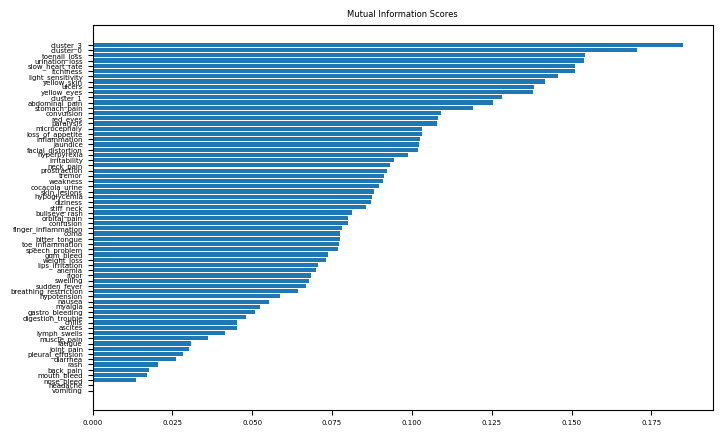

In [ ]:
def plot_mi_scores(scores):
    plt.rcParams.update({'font.size': 5})
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    plt.rcParams.update({'font.size': 10})


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [ ]:
OHE = OneHotEncoder(handle_unknown='ignore', sparse=False)
target_col = pd.DataFrame(OHE.fit_transform(target.values.reshape(-1,1)))
acc = 0
for i in range(11):
  model = svm.SVC()
  score = cross_val_score(model, train, target_col[i], cv=5, scoring='roc_auc').mean()
  acc += score
  print(f"Accuracy for index-{i} : {score}")
print(f"Mean : {acc/11*100}%")

In [ ]:
best_model = svm.SVC(probability=True).fit(train, target)
pred = best_model.predict_proba(test)
top_3_pred = np.argsort(-pred, axis=1)[:,:3]
top_3_pred = enc.inverse_transform(top_3_pred.reshape(-1, 1))
#print(top_3_pred)
top_3_pred = top_3_pred.reshape(303,3)
top_3_pred[:10]

In [ ]:
pred_sub = np.array([])
for i in range(303):
  pred_sub = np.append(pred_sub, top_3_pred[i][0] + ' ' + top_3_pred[i][1] + ' ' + top_3_pred[i][2])
sub['prognosis'] = pred_sub

In [ ]:
sub.to_csv('submission.csv', columns=['id', 'prognosis'], index=False)

In [ ]:
OHE = OneHotEncoder(handle_unknown='ignore', sparse=False)
target_col = pd.DataFrame(OHE.fit_transform(target.values.reshape(-1,1)))

In [ ]:
mi_score_0 = make_mi_scores(train, target_col[10], train.dtypes == int)
plot_mi_scores(mi_score_0)

In [ ]:
def fe2(df):
  cluster_4 = ['sudden_fever', 'headache', 'muscle_pain', 'joint_pain', 'fatigue', 'rash']
  cluster_5 = ['sudden_fever', 'headache', 'neck_pain', 'confusion', 'tremor', 'paralysis']
  cluster_6 = ['sudden_fever', 'headache', 'muscle_pain', 'joint_pain', 'weakness', 'vomiting', 'gastro_bleeding']
  #df['cluster_4'] = df[cluster_4].sum(axis=1)
  #df['cluster_5'] = df[cluster_5].mean(axis=1)
  #df['cluster_6'] = df[cluster_6].mean(axis=1)

fe2(train)
fe2(test)

In [ ]:
mi_score_8 = make_mi_scores(train, target, train.dtypes == int)
plot_mi_scores(mi_score_8)

In [ ]:
sub_2_model = svm.SVC(probability=True).fit(train, target)
sub_2_pred = sub_2_model.predict_proba(test)
top_3_pred = np.argsort(-sub_2_pred, axis=1)[:,:3]
top_3_pred = enc.inverse_transform(top_3_pred.reshape(-1, 1))
#print(top_3_pred)
top_3_pred = top_3_pred.reshape(303,3)
top_3_pred[:10]
pred_sub_2 = np.array([])
for i in range(303):
  pred_sub_2 = np.append(pred_sub_2, top_3_pred[i][0] + ' ' + top_3_pred[i][1] + ' ' + top_3_pred[i][2])
sub['prognosis'] = pred_sub_2

In [ ]:
sub.to_csv('submission_3.csv', columns=['id', 'prognosis'], index=False)

In [ ]:
sub.head(10)

In [ ]:
sub.to_csv('submission_3.csv', columns=['id', 'prognosis'], index=False)

In [ ]:
mi_score_8 = make_mi_scores(train, target, train.dtypes == int)
plot_mi_scores(mi_score_8)

In [ ]:
train['prognosis'] = target

In [1]:
sns.heatmap(train.corr())

NameError: ignored

In [ ]:
train.corr()['prognosis'].sort_values()

In [ ]:
gejala = {'hyperbilirubinemia': ['jaundice', 'yellow_skin' , 'yellow_eyes'],
            #'abnormal_hemostasis': ['mouth_bleed', 'nose_bleed', 'gastro_bleeding', 'gum_bleed'],
            #'anasarca': ['pleural_effusion', 'ascites'],
            'kidney_failure': ['urination_loss' , 'cocacola_urine'],
            #'meningitis': ['orbital_pain', 'neck_pain', 'light_sensitivity', 'stiff_neck'],
            #'neurological_focal': ['coma', 'convulsion', 'confusion', 'paralysis', 'speech_problem'],
            #'fever': ['sudden_fever', 'rigor', 'hyperpyrexia' ],
            #'hypereosinophilia': ['rash', 'swelling'],
            #'digestive_issues': ['vomiting', 'diarrhea', 'nausea', 'stomach_pain', 'abdominal_pain'],
            #'skin_appendages': ['skin_lesions', 'toe_inflammation', 'finger_inflammation', 'lips_irritation', 'ulcers', 'toenail_loss'],
            #'flu-like_illness': ['headache', 'muscle_pain', 'joint_pain', 'chills', 'myalgia', 'fatigue']
}

In [ ]:
#train.corr()['prognosis'][[i for i in gejala]]